## Final Code - GAIA 

In [171]:
# import libraries 
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd
pd.options.display.max_rows
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Reshape
from tensorflow.keras import Sequential
import time
import numpy as np
# SMOTE 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
# Cluster Centroids 
from imblearn.under_sampling import ClusterCentroids
# Model 1 
from sklearn.ensemble import GradientBoostingClassifier # model 1 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error
import xgboost as xgb # model 2
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier # model 3
from sklearn.ensemble import RandomForestClassifier # model 4 
from sklearn import svm # model 5 
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression # model 6
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV # Grid Search 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

We are going to open the final table obtained from GAIA pre-processing step. The final table is made up by 8 columns, in which the column "Class" represents the presence/absence of strains.  

In [146]:
# Load the data and change columns names: 
data = pd.read_excel('final.xlsm', header=None)
data.columns =['Strain_ID', 'Genome_length', 'Ratio_1kbp_bins_covered', 'Ratio_GC-content_uncovered_bins', 'Ratio_N-content_uncovered_bins', 'Reads_mapped', 'Total_reads', 'Class']
# Drop the Strain_ID column, we are not interested in it: 
data = data.drop(['Strain_ID'], axis=1)
# Normalize columns except Class column: 
sc = StandardScaler()
data[['Genome_length', 'Ratio_1kbp_bins_covered', 'Ratio_GC-content_uncovered_bins', 'Ratio_N-content_uncovered_bins', 'Reads_mapped', 'Total_reads']] = sc.fit_transform(data[['Genome_length', 'Ratio_1kbp_bins_covered', 'Ratio_GC-content_uncovered_bins', 'Ratio_N-content_uncovered_bins', 'Reads_mapped', 'Total_reads']])


# 1. Prepare data: with this function we divide the dataset into X and y (y=Class, variable of interest). 
# Then, we split the data into train and test (20% will be the test): 

def prepare_data(data,random_state=12):
    X = data.drop('Class', axis=1)
    y = data['Class']
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=random_state)
    dftrain = [xtrain, ytrain]
    dftest = [xtest, ytest]
    return pd.concat(dftrain, axis=1), pd.concat(dftest, axis=1)

In [147]:
data.head()

,Genome_length,Ratio_1kbp_bins_covered,Ratio_GC-content_uncovered_bins,Ratio_N-content_uncovered_bins,Reads_mapped,Total_reads,Class
0,0.228558,-0.219520,1.078705,-0.168407,-0.117813,-0.420667,0
1,4.039962,-0.220521,0.485007,-0.154483,-0.117818,-0.420667,0
2,0.075952,-0.220521,0.696596,-0.168520,-0.117818,-0.420667,0
3,2.245584,-0.220521,0.590566,-0.168305,-0.117818,-0.420667,0
4,0.608627,-0.220521,0.683660,-0.168520,-0.117818,-0.420667,0


Let's check the distribution of the 2 classes: presence (1) and absence (0) of strains: 

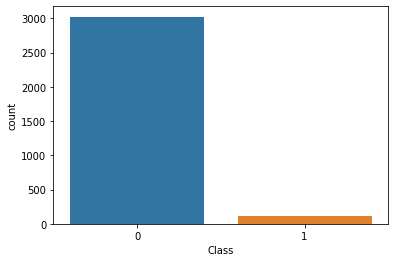

In [148]:
sns.countplot(data['Class']) # initial distribution of data 

As showed by the count plot, the distribution of data is imbalanced. This means that we have to try to balance the 2 classes before train the models. 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       567
           1       0.98      1.00      0.99       643

    accuracy                           0.99      1210
   macro avg       0.99      0.99      0.99      1210
weighted avg       0.99      0.99      0.99      1210

[[554  13]
 [  1 642]]
0.011570247933884297
              precision    recall  f1-score   support

           0       0.71      0.94      0.81       567
           1       0.93      0.66      0.77       643

    accuracy                           0.79      1210
   macro avg       0.82      0.80      0.79      1210
weighted avg       0.82      0.79      0.79      1210

[[534  33]
 [221 422]]
0.20991735537190082
              precision    recall  f1-score   support

           0       0.70      0.93      0.80       567
           1       0.92      0.65      0.76       643

    accuracy                           0.79      1210
   macro avg       0.81      0.79      0.

,Model,F1-score
0,Random Forest Classifier,0.99
1,SVM,0.76
2,Logistic Regression,0.75


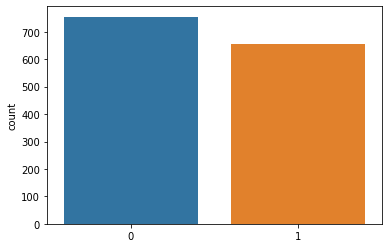

In [149]:
# SMOTE method: oversampling 

# Defining X and y 
X = data.drop(['Class'], axis = 1 )
y = data['Class']

# Resampling with SMOTE algorithm 
X_smote, y_smote = SMOTE().fit_resample(X, y)

# Splitting data 
xtrain_sm, xtest_sm, ytrain_sm, ytest_sm = train_test_split(X_smote, y_smote, test_size=0.2, random_state=12)

# Testing the models with SMOTE 
smote = SMOTE(random_state=12)
pipeline = Pipeline([('smote', smote), ('rfc', RandomForestClassifier(random_state=12))]) # creating the pipeline we want to use  
pipeline.fit(xtrain_sm, ytrain_sm) # fitting  
pred_smote = pipeline.predict(xtest_sm) # predicting 
print(classification_report(ytest_sm, pred_smote)) # results
print(confusion_matrix(ytest_sm,pred_smote))
print(mean_absolute_error(ytest_sm, pred_smote))
sns.countplot(pred_smote)

# 2 

pipeline_svm = Pipeline([('smote', smote), ('svm', svm.SVC(random_state=12))]) # creating the pipeline we want to use  
pipeline_svm.fit(xtrain_sm, ytrain_sm) # fitting  
pred_smote = pipeline_svm.predict(xtest_sm) # predicting 
print(classification_report(ytest_sm, pred_smote)) # results
print(confusion_matrix(ytest_sm,pred_smote))
print(mean_absolute_error(ytest_sm, pred_smote))
sns.countplot(pred_smote)

# 3

pipeline_lr = Pipeline([('smote', smote), ('lr', LogisticRegression(random_state=12))]) # creating the pipeline we want to use  
pipeline_lr.fit(xtrain_sm, ytrain_sm) # fitting  
pred_smote = pipeline_lr.predict(xtest_sm) # predicting 
print(classification_report(ytest_sm, pred_smote)) # results
print(confusion_matrix(ytest_sm,pred_smote))
print(mean_absolute_error(ytest_sm, pred_smote))
sns.countplot(pred_smote)

final_results = pd.DataFrame({'Model' : ['Random Forest Classifier', 'SVM', 'Logistic Regression'], 'F1-score' : [0.99, 0.76, 0.75]})
final_results

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.93      1.00      0.96        25

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48

[[21  2]
 [ 0 25]]
0.041666666666666664
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        23
           1       0.74      0.68      0.71        25

    accuracy                           0.71        48
   macro avg       0.71      0.71      0.71        48
weighted avg       0.71      0.71      0.71        48

[[17  6]
 [ 8 17]]
0.2916666666666667
              precision    recall  f1-score   support

           0       0.77      0.43      0.56        23
           1       0.63      0.88      0.73        25

    accuracy                           0.67        48
   macro avg       0.70      0.66      0.64       

,Model,F1-score
0,Random Forest Classifier,0.96
1,SVM,0.71
2,Logistic Regression,0.73


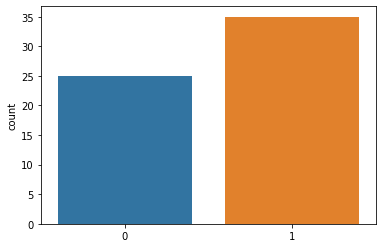

In [150]:
# Cluster Centroids: under sampling 

CC = ClusterCentroids(random_state=12)
X_res, y_res = CC.fit_sample(X, y)
xtrain_cc, xtest_cc, ytrain_cc, ytest_cc = train_test_split(X_res, y_res, test_size=0.2, random_state=12)

# testing 

pipeline_cc = Pipeline([('CC', CC), ('rfc', RandomForestClassifier(random_state=12))]) # creating the pipeline we want to use  
pipeline_cc.fit(xtrain_cc, ytrain_cc) # fitting  
pred_cc = pipeline_cc.predict(xtest_cc) # predicting 
print(classification_report(ytest_cc, pred_cc)) # results
print(confusion_matrix(ytest_cc,pred_cc))
print(mean_absolute_error(ytest_cc, pred_cc))
sns.countplot(pred_cc)

# 2 
pipeline_cc_svm = Pipeline([('CC', CC), ('svm', svm.SVC(random_state=12))]) # creating the pipeline we want to use  
pipeline_cc_svm.fit(xtrain_cc, ytrain_cc) # fitting  
pred_cc_svm = pipeline_cc_svm.predict(xtest_cc) # predicting 
print(classification_report(ytest_cc, pred_cc_svm)) # results
print(confusion_matrix(ytest_cc,pred_cc_svm))
print(mean_absolute_error(ytest_cc, pred_cc_svm))
sns.countplot(pred_cc_svm)

# 3 
pipeline_cc_lr = Pipeline([('CC', CC), ('lr', LogisticRegression(random_state=12))]) # creating the pipeline we want to use  
pipeline_cc_lr.fit(xtrain_cc, ytrain_cc) # fitting  
pred_cc_lr = pipeline_cc_lr.predict(xtest_cc) # predicting 
print(classification_report(ytest_cc, pred_cc_lr)) # results
print(confusion_matrix(ytest_cc,pred_cc_lr))
print(mean_absolute_error(ytest_cc, pred_cc_lr))
sns.countplot(pred_cc_lr)


final_results_cc = pd.DataFrame({'Model' : ['Random Forest Classifier', 'SVM', 'Logistic Regression'], 'F1-score' : [0.96, 0.71, 0.73]})

final_results_cc

Then we used a generative model, the variational autoencoder (VAE) in order to generate new synthetic data: 

In [151]:
# 2. Strains function: with this function we are going to create two others dataframes (one for training and one for testing)
# considering only the data corresponded to Class=1 (presence of strain). Why? Because we are going to train a VAE 
# in oerder to obtain new data that follow the statistical distribution of the presence of strain (in order to increase this class). 

def strain(dftrain, dftest):
    ''' 1. select only Class = 1 values '''
    strain = dftrain[dftrain.Class==1].sample(frac=1)
    ''' 2. drop class from the dataset '''
    strain = strain.drop(['Class'], axis=1)
    straintest = dftest[dftest.Class==1].sample(frac=1)
    straintest = straintest.drop(['Class'], axis=1)
    return strain, straintest  

In [152]:
# This code is taken from Tensorflow tutorial on VAEs. It's turned from a CNN to a simple neuralnet which is more appropriate for our case here.

# almost the standard for activation these days
relu = tf.nn.relu


class VAE(tf.keras.Model):
    """
    A VAE class inhereted from keras.Model

    parameters:
    ndim (int): number of dimensions of the input data
    latent_dim (int): number of dimensions of the latent variable

    attributes:
    ndim (int): number of dimensions of the input
    latent_dim (int): number of dimensions of the latent variable
    inference_net (keras.Sequential): The inference model that takes an input of size=(None, ndim) and return a matrix of size=(None, latent_dim)
    generative_net (keras.Sequential): The generative model that takes an input of size=(None, latent_dim) and return a matrix of size=(None, ndim)
    """
    def __init__(self, ndim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim  
        self.ndim = ndim        
        self.inference_net = Sequential(
            [
                InputLayer(input_shape=(ndim,)),
                Dense(100, activation=relu),
                Dense(2 * latent_dim)
            ]
        )
        
        self.generative_net = Sequential(
            [
                InputLayer(input_shape=(latent_dim,)),
                Dense(100, activation=relu),
                Dense(ndim)
            ])

    @tf.function
    def sample(self, num_samples=100, eps=None):
        """
        Given an input noise of size (num_samples, latent_dim), generate samples of size (num_samples, ndim)

        parameters:
        num_samples (int): number of samples
        eps (numpy.ndarray): input noise. if specified, num_samples is ignored

        returns:
        numpy.ndarray: the decoded samples
        """
        if eps is None:
            eps = tf.random.normal(shape=(num_samples, self.latent_dim))
        return self.decode(eps)

    def encode(self, x):
        """
        
        parameters:
        x (numpy.ndarray): the input data with size (None, ndim)

        returns:
        numpy.ndarray: the mean of the latent variables
        numpy.ndarray: the log variance of the latent variables
        """
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        """
        Reparameterize the input for backpropagation

        parameters:
        mean (numpy.ndarray): the mean of the latent variables
        logvar (numpy.ndarray): the log variance of the latent variables

        returns:
        numpy.ndarray: the noise samples from a normal distribution around mean with standard deviation exp(logvar / 2)
        """
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z):
        """
        Given an input noise generates the decoded samples

        parameters:
        z (numpy.ndarray): the input noise (None, latent_dim)

        returns:
        numpy.ndarray: the decoded samples of size (None, ndim)
        """
        return self.generative_net(z)

In [153]:
# a function for computing the KL term of Gaussian distribution
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
                         axis=raxis)

# a function to compute the loss of the VAE
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    logvar = tf.clip_by_value(logvar, -88., 88.)
    z = model.reparameterize(mean, logvar)
    xmean = model.decode(z)
    logpx_z = -tf.reduce_sum((x - xmean) ** 2, axis=1)  # ad-hoc l2 loss that is pretty close to log-prob of a gaussian distribution withtout taking into account the variance
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# A function that given the model computes the loss, the gradients and apply the parameter update
@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [154]:
def train(xtrain, xtest, model=None, load=False, filepath=None):
    optimizer = tf.keras.optimizers.Adam(1e-3)
    epochs = 2000
    latent_dim = 6 # number of our columns
    num_train, ndim = xtrain.shape
    num_test, _ = xtest.shape
    if model is None:
        model = VAE(ndim, latent_dim)
    if load and filepath is not None:
        model.load_weights(filepath=filepath)
        return model
    else:
        batch_size = 32
        train_dataset = tf.data.Dataset.from_tensor_slices(xtrain.values.astype(np.float32)).shuffle(num_train).batch(
            batch_size)

        test_dataset = tf.data.Dataset.from_tensor_slices(xtest.values.astype(np.float32)).shuffle(num_test).batch(num_test)

        for epoch in range(1, epochs + 1):
            start_time = time.time()
            for train_x in train_dataset:
                compute_apply_gradients(model, train_x, optimizer)
            end_time = time.time()

            if epoch % 100 == 0:
                loss = tf.keras.metrics.Mean()
                for test_x in test_dataset:
                    loss(compute_loss(model, test_x))
                elbo = -loss.result()
                print('Epoch: {}, Test set psudo-ELBO: {}, '
                      'time elapse for current epoch {}'.format(epoch, elbo, end_time - start_time))
                model.save_weights('saved_models/model_%d_at_%d' % (latent_dim, epoch))
    return model

In [155]:
# Function to increase the minority class: 
def increasing(data, model):
    np.random.seed(12)
    ''' num_samples = number of values of majority class (0) '''
    num_samples = num_samples = data['Class'].value_counts()[0] - data['Class'].value_counts()[1]  # values of class == 1 
    samples = model.sample(num_samples=num_samples).numpy()
    ''' creating new dataframe with sampled values '''
    dfnew = pd.DataFrame(samples, columns=data.columns.drop('Class'))
    dfnew['Class'] = np.ones(len(samples), dtype=np.int)
    # dfnew = pd.concat((data, dfnew), ignore_index=True).sample(frac=1)
    return dfnew

In [156]:
# Use the function to obtain 2 dataframes: 
dftrain, dftest = prepare_data(data)
# get the strains'presence distribution 
strain, straintest = strain(dftrain, dftest)
# get the traied VAE model
model = train(strain, straintest)

Epoch: 100, Test set psudo-ELBO: -7.681596279144287, time elapse for current epoch 0.007921218872070312
Epoch: 200, Test set psudo-ELBO: -6.792724609375, time elapse for current epoch 0.023607969284057617
Epoch: 300, Test set psudo-ELBO: -6.459743976593018, time elapse for current epoch 0.012368202209472656
Epoch: 400, Test set psudo-ELBO: -6.373538970947266, time elapse for current epoch 0.008231163024902344
Epoch: 500, Test set psudo-ELBO: -5.904240131378174, time elapse for current epoch 0.01005697250366211
Epoch: 600, Test set psudo-ELBO: -5.851219654083252, time elapse for current epoch 0.008301973342895508
Epoch: 700, Test set psudo-ELBO: -5.792105197906494, time elapse for current epoch 0.011199951171875
Epoch: 800, Test set psudo-ELBO: -5.4956231117248535, time elapse for current epoch 0.008545160293579102
Epoch: 900, Test set psudo-ELBO: -5.703393936157227, time elapse for current epoch 0.008195161819458008
Epoch: 1000, Test set psudo-ELBO: -5.563518524169922, time elapse for 

In [158]:
# augment the data using the VAE model
data_increased = increasing(dftrain, model)

##### Quality control 

The first quality control we did has been checking the mean of two variables of interest: Ratio_1kbp_bins_covered and Reads Mapped. We selected these two variables because we previously saw that the coverage has a greate influence on the number of predicted strains. 

In [159]:
data.groupby('Class').mean() #1.53619 and 1.532687

,Genome_length,Ratio_1kbp_bins_covered,Ratio_GC-content_uncovered_bins,Ratio_N-content_uncovered_bins,Reads_mapped,Total_reads
Class,,,,,,
0,-0.016082,-0.06098,0.016543,0.003079,-0.060841,-0.005691
1,0.405132,1.53619,-0.416753,-0.077574,1.532687,0.143355


In [17]:
data_increased.groupby('Class').mean() #1.586048 and 1.500616

,Genome_length,Ratio_1kbp_bins_covered,Ratio_GC-content_uncovered_bins,Ratio_N-content_uncovered_bins,Reads_mapped,Total_reads
Class,,,,,,
1,0.234057,1.60099,-0.408038,-0.135459,1.427738,0.182888


In [25]:
# Merging the new and the original data: we have to create the final dataset
merged_data = pd.concat((data, data_increased), ignore_index=True) # .sample(frac=1)

# Shuffle data 
from sklearn.utils import shuffle
merged_data = shuffle(merged_data)

In [26]:
merged_data.head()

,Genome_length,Ratio_1kbp_bins_covered,Ratio_GC-content_uncovered_bins,Ratio_N-content_uncovered_bins,Reads_mapped,Total_reads,Class
2109,-0.398347,-0.211648,-1.529774,-0.167432,-0.113029,-0.619181,0
4661,-0.115448,3.012359,-0.487116,-0.017871,6.801397,1.447541,1
5297,2.645734,2.204056,0.077926,-0.387763,0.512216,-0.405978,1
1107,-0.793125,-0.183680,0.829575,-0.168520,-0.117813,1.944562,0
969,-0.410265,-0.220521,1.647923,-0.168520,-0.117818,1.944562,0


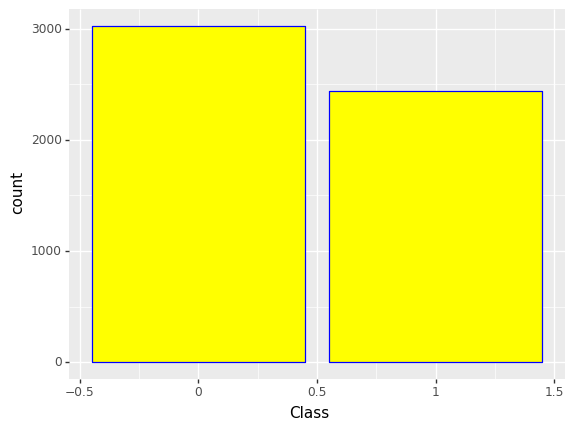

<ggplot: (327990797)>

In [162]:
# Bar plot with ggplot of SMOTE distribution 
from plotnine import *
p = ggplot(merged_data) + geom_bar(aes(x='Class'), fill = "yellow", colour = "blue")
p

Once we obtained well - balanced data, we could test again the machine learning models of classification

In [163]:
# Testing the models on the new data 
# Defining X and Y 
X_final = merged_data.drop('Class', axis=1) # data increased with VAE 
y_final = merged_data['Class']

# Split the data 
xtrain_f, xtest_f, ytrain_f, ytest_f = train_test_split(X_final, y_final, test_size=0.2, random_state=12)

In [164]:
# Model 1 
rfc = RandomForestClassifier(n_estimators = 200, random_state = 12)
rfc.fit(xtrain_f, ytrain_f)
pred_rfc = rfc.predict(xtest_f)

print(classification_report(ytest_f, pred_rfc))
print(confusion_matrix(ytest_f, pred_rfc))

# Calculating Sensitivity and Specificity from confusion matrix : 
cm1 = (confusion_matrix(ytest_f, pred_rfc)) 
total1 = sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1 = (cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])  # TN / (TN + FP)
print('Specificity : ', specificity1)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       583
           1       0.99      1.00      0.99       510

    accuracy                           0.99      1093
   macro avg       0.99      0.99      0.99      1093
weighted avg       0.99      0.99      0.99      1093

[[579   4]
 [  2 508]]
Accuracy :  0.9945105215004575
Sensitivity :  0.9931389365351629
Specificity :  0.996078431372549


In [165]:
# Model 2
SVM = svm.SVC(random_state = 12)
SVM.fit(xtrain_f, ytrain_f)
pred_SVM = SVM.predict(xtest_f)

print(classification_report(ytest_f, pred_SVM)) 
print(confusion_matrix(ytest_f, pred_SVM)) 

# Calculating Sensitivity and Specificity from confusion matrix : 
cm2 = (confusion_matrix(ytest_f, pred_SVM)) 
total2=sum(sum(cm2))
#####from confusion matrix calculate accuracy
accuracy2=(cm2[0,0]+cm2[1,1])/total2
print ('Accuracy : ', accuracy2)

sensitivity2 = cm2[0,0]/(cm2[0,0]+cm2[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity2 )

specificity2 = cm2[1,1]/(cm2[1,0]+cm2[1,1]) # TN / (TN + FP)
print('Specificity : ', specificity2)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       583
           1       0.93      0.83      0.88       510

    accuracy                           0.89      1093
   macro avg       0.90      0.89      0.89      1093
weighted avg       0.89      0.89      0.89      1093

[[549  34]
 [ 86 424]]
Accuracy :  0.8902104300091491
Sensitivity :  0.9416809605488851
Specificity :  0.8313725490196079


In [166]:
# Model 3
logreg = LogisticRegression(solver='lbfgs', random_state = 12)
logreg.fit(xtrain_f, ytrain_f)
pred_logreg = logreg.predict(xtest_f)

print(classification_report(ytest_f, pred_logreg)) 
print(confusion_matrix(ytest_f, pred_logreg)) 

# Calculating Sensitivity and Specificity from confusion matrix : 
cm3 = (confusion_matrix(ytest_f, pred_logreg)) 
total3=sum(sum(cm3))
#####from confusion matrix calculate accuracy
accuracy3=(cm3[0,0]+cm3[1,1])/total3
print ('Accuracy : ', accuracy3)

sensitivity3 = cm3[0,0]/(cm3[0,0]+cm3[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity3 )

specificity3 = cm3[1,1]/(cm3[1,0]+cm3[1,1]) # TN / (TN + FP)
print('Specificity : ', specificity3)

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       583
           1       0.89      0.73      0.80       510

    accuracy                           0.83      1093
   macro avg       0.84      0.82      0.83      1093
weighted avg       0.84      0.83      0.83      1093

[[538  45]
 [140 370]]
Accuracy :  0.8307410795974383
Sensitivity :  0.9228130360205832
Specificity :  0.7254901960784313


In [34]:
# Model 4 
gbc = GradientBoostingClassifier(random_state=12)
gbc.fit(xtrain_f,ytrain_f)
predict_gbc = gbc.predict(xtest_f)

print(classification_report(ytest_f, predict_gbc))
print(confusion_matrix(ytest_f, predict_gbc))

# error between data generated and original data 
print(mean_absolute_error(predict_gbc, ytest_f))

# Calculating Sensitivity and Specificity from confusion matrix : 
cm1 = (confusion_matrix(ytest_f, predict_gbc)) 
total1 = sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1 = (cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])  # TN / (TN + FP)
print('Specificity : ', specificity1)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       614
           1       0.99      0.98      0.98       479

    accuracy                           0.98      1093
   macro avg       0.98      0.98      0.98      1093
weighted avg       0.98      0.98      0.98      1093

[[608   6]
 [ 11 468]]
0.01555352241537054
Accuracy :  0.9844464775846294
Sensitivity :  0.990228013029316
Specificity :  0.9770354906054279


In [167]:
# Model 5 
xgb_boost = xgb.XGBClassifier(random_state=12)
xgb_boost.fit(xtrain_f, ytrain_f)
predict_xgb_boost = xgb_boost.predict(xtest_f)

print(classification_report(ytest_f, predict_xgb_boost))
print(confusion_matrix(ytest_f, predict_xgb_boost))

# error between data generated and original data 
print(mean_absolute_error(predict_xgb_boost, ytest_f))

# Calculating Sensitivity and Specificity from confusion matrix : 
cm2 = (confusion_matrix(ytest_f, predict_xgb_boost)) 
total2 = sum(sum(cm2))
#####from confusion matrix calculate accuracy
accuracy2 = (cm2[0,0]+cm2[1,1])/total2
print ('Accuracy : ', accuracy2)

sensitivity2 = cm2[0,0]/(cm2[0,0]+cm2[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity2 )

specificity2 = cm2[1,1]/(cm2[1,0]+cm2[1,1])  # TN / (TN + FP)
print('Specificity : ', specificity2)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       583
           1       0.99      0.99      0.99       510

    accuracy                           0.99      1093
   macro avg       0.99      0.99      0.99      1093
weighted avg       0.99      0.99      0.99      1093

[[577   6]
 [  3 507]]
0.008234217749313814
Accuracy :  0.9917657822506862
Sensitivity :  0.9897084048027445
Specificity :  0.9941176470588236


In [169]:
# Model 6
ada = AdaBoostClassifier(random_state=12)
ada.fit(xtrain_f,ytrain_f)
predict_ada = ada.predict(xtest_f)

print(classification_report(ytest_f, predict_ada))
print(confusion_matrix(ytest_f, predict_ada))

# error between data generated and original data 
print(mean_absolute_error(predict_ada, ytest_f))

# Calculating Sensitivity and Specificity from confusion matrix : 
cm = (confusion_matrix(ytest_f, predict_ada)) 
total = sum(sum(cm))
#####from confusion matrix calculate accuracy
accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity )

specificity = cm[1,1]/(cm[1,0]+cm[1,1])  # TN / (TN + FP)
print('Specificity : ', specificity)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       583
           1       0.98      0.98      0.98       510

    accuracy                           0.98      1093
   macro avg       0.98      0.98      0.98      1093
weighted avg       0.98      0.98      0.98      1093

[[571  12]
 [ 10 500]]
0.020128087831655993
Accuracy :  0.979871912168344
Sensitivity :  0.9794168096054888
Specificity :  0.9803921568627451


Now, in order to obtain the best hyperparameters for each model we are going to apply the GridSearch - Hyperparameters tuning. Moreover, we compare the models to each other to check which is the best (higher F1-score). 

In [172]:
model_params = {
    'SVM' : {
        'Model': svm.SVC(random_state = 1),
        'Params': {
            'C' : [1,10,100,1000],
            'gamma' : [1e-3, 1e-4], 
        }
    },
    'Random_forest' : {
        'Model': RandomForestClassifier(random_state = 1),
        'Params': {
            'n_estimators' : [100,500,800],
            'oob_score' : [False, True]
        }
    },
    'Logistic_regression' : {
        'Model': LogisticRegression(random_state = 1),
        'Params': {
        'C' : [1,10,100,1000],
            'penalty' : ['l1', 'l2'],
            'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
},
    'Gradient_Boosting' : {
        'Model' : GradientBoostingClassifier(random_state = 1),
        'Params' : {
            'ccp_alpha' : [0.0,0.5,0.7], 
            'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 
            'n_estimators':[100,200,400,600,800]
        }
    },
    
    'XGB_Boosting' : {
        'Model' : xgb.XGBClassifier(random_state = 1),
        'Params' : {
            'base_score' : [0.0,0.5,0.7], 
            'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 
            'n_estimators':[100,200,400,600,800]  
        }
    }, 
    
    'Ada_Boosting' : {
        'Model' : AdaBoostClassifier(random_state = 1),
        'Params' : {
            'algorithm' : ['SAMME', 'SAMME.R'], 
            'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 
            'n_estimators':[100,200,400,600,800]  
        }
    } 
} 

In [178]:
scores = []
np.random.seed(12)
for model_name, mp in model_params.items():
    final_model = GridSearchCV(mp['Model'], mp['Params'], cv=5, return_train_score=False, scoring='f1_micro')
    final_model.fit(X_final,y_final)
    scores.append({
        'Model': model_name,
        'Best score' : final_model.best_score_,
        'Best params': final_model.best_params_
    })

In [179]:
final_params_table = pd.DataFrame(scores,columns=['Model', 'Best score', 'Best params']).sort_values(by=['Best score'], ascending=False)

In [180]:
final_params_table

,Model,Best score,Best params
1,Random_forest,0.991217,"{'n_estimators': 500, 'oob_score': False}"
4,XGB_Boosting,0.991217,"{'base_score': 0.5, 'learning_rate': 0.2, 'n_e..."
3,Gradient_Boosting,0.987923,"{'ccp_alpha': 0.0, 'learning_rate': 0.1, 'n_es..."
5,Ada_Boosting,0.983166,"{'algorithm': 'SAMME.R', 'learning_rate': 0.3,..."
0,SVM,0.870082,"{'C': 1000, 'gamma': 0.001}"
2,Logistic_regression,0.843733,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}"


In [181]:
final_params_table.iloc[1,2] # to check the best parameters of the XGB_Boosting

{'base_score': 0.5, 'learning_rate': 0.2, 'n_estimators': 600}

In [182]:
final_model = xgb.XGBClassifier(base_score = 0.7, learning_rate = 0.3, n_estimators = 800, random_state=12)
final_model.fit(xtrain_f, ytrain_f)
final_predict = final_model.predict(xtest_f)

print(classification_report(ytest_f, final_predict))
print(confusion_matrix(ytest_f, final_predict))

# Calculating Sensitivity and Specificity from confusion matrix : 
cm2 = (confusion_matrix(ytest_f, final_predict)) 
total2 = sum(sum(cm2))
#####from confusion matrix calculate accuracy
accuracy2 = (cm2[0,0]+cm2[1,1])/total2
print ('Accuracy : ', accuracy2)

sensitivity2 = cm2[0,0]/(cm2[0,0]+cm2[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity2 )

specificity2 = cm2[1,1]/(cm2[1,0]+cm2[1,1])  # TN / (TN + FP)
print('Specificity : ', specificity2)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       583
           1       0.99      0.99      0.99       510

    accuracy                           0.99      1093
   macro avg       0.99      0.99      0.99      1093
weighted avg       0.99      0.99      0.99      1093

[[579   4]
 [  4 506]]
Accuracy :  0.9926806953339433
Sensitivity :  0.9931389365351629
Specificity :  0.9921568627450981


Final Model
[[579   4]
 [  4 506]]


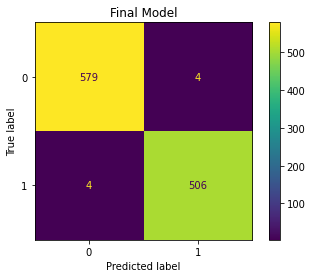

In [183]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [('Final Model')]
for title in titles_options:
    disp = plot_confusion_matrix(final_model, xtest_f, ytest_f)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

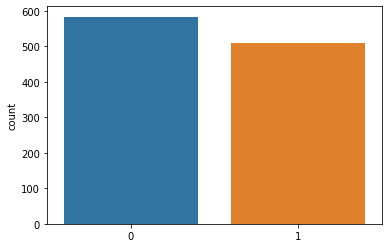

In [184]:
sns.countplot(final_predict)

In [185]:
# Creating pickle object of the final model : 
import pickle    

#save the model
pickle.dump(final_model, open('final_model.sav', 'wb'))
# save the scaler
pickle.dump(sc, open('scaler.sav', 'wb'))